# Проект по моделям машинного обучения с учителем (supervised learning) - Методы на основе деревьев

----

## ЦЕЛЬ: Создать модель предсказания того, уйдёт ли абонент в отток (churn).

----

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,plot_confusion_matrix,classification_report
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier

In [3]:
df = pd.read_csv('../data/Telco-Customer-Churn.csv')

In [4]:
df.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges  Churn  
0           Electronic check          29.85         29.85     No  
1               Mailed check          56.95       1889.50     No  
2               Mailed check          53.85        108.15    Yes  
3  Bank transfer (automatic)          42.30       1840.75     No  
4           Electronic check          70.70        151.65    Yes  

[5 rows x 21 columns]

## Часть 1: Общие характеристики данных

**С помощью метода .info() проверим типы данных для колонок, а также есть ли отсутствующие значения в датафрейме.**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


**Выведем статистические метрики для числовых колонок с помощью .describe().**

In [5]:
df.describe()

SeniorCitizen       tenure  MonthlyCharges  TotalCharges
count    7032.000000  7032.000000     7032.000000   7032.000000
mean        0.162400    32.421786       64.798208   2283.300441
std         0.368844    24.545260       30.085974   2266.771362
min         0.000000     1.000000       18.250000     18.800000
25%         0.000000     9.000000       35.587500    401.450000
50%         0.000000    29.000000       70.350000   1397.475000
75%         0.000000    55.000000       89.862500   3794.737500
max         1.000000    72.000000      118.750000   8684.800000

# Часть 2:  Исследование данных (Exploratory Data Analysis)

## Исследование признаков

**Проверим, что в этих данных нет отсутствующих значений - для этого выведем количество значений NaN отдельно для каждой колонки.**

In [6]:
df.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

**Построим график CountPlot для проверки сбалансированности значений колонки с классами (Churn).**

<AxesSubplot:xlabel='Churn', ylabel='count'>

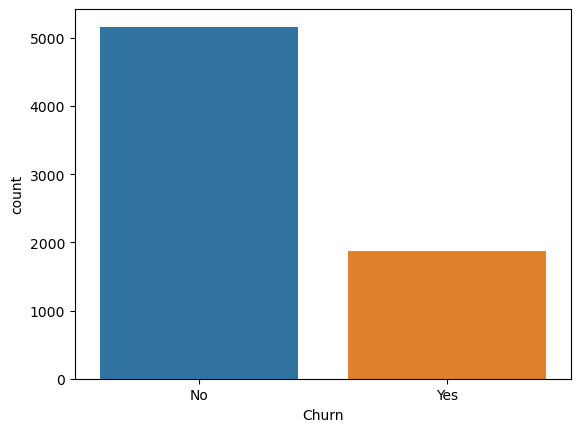

In [7]:
sns.countplot(data=df,x='Churn')

In [10]:
# видна несбалансированность классов

**Исследуем распределение колонки TotalCharges по различным категориям Churn с помощью графика Box Plot или Violin Plot.**

<AxesSubplot:xlabel='Churn', ylabel='TotalCharges'>

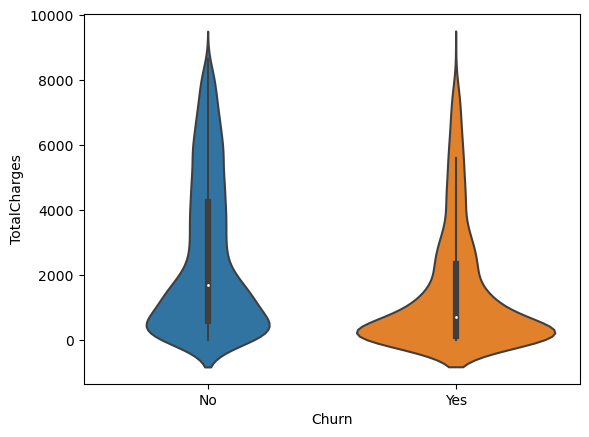

In [8]:
sns.violinplot(data=df,x='Churn',y='TotalCharges')

**Построим график boxplot с распределением колонки TotalCharges для различных типов контрактов, а также добавим раскраску цветами по колонке Churn.**

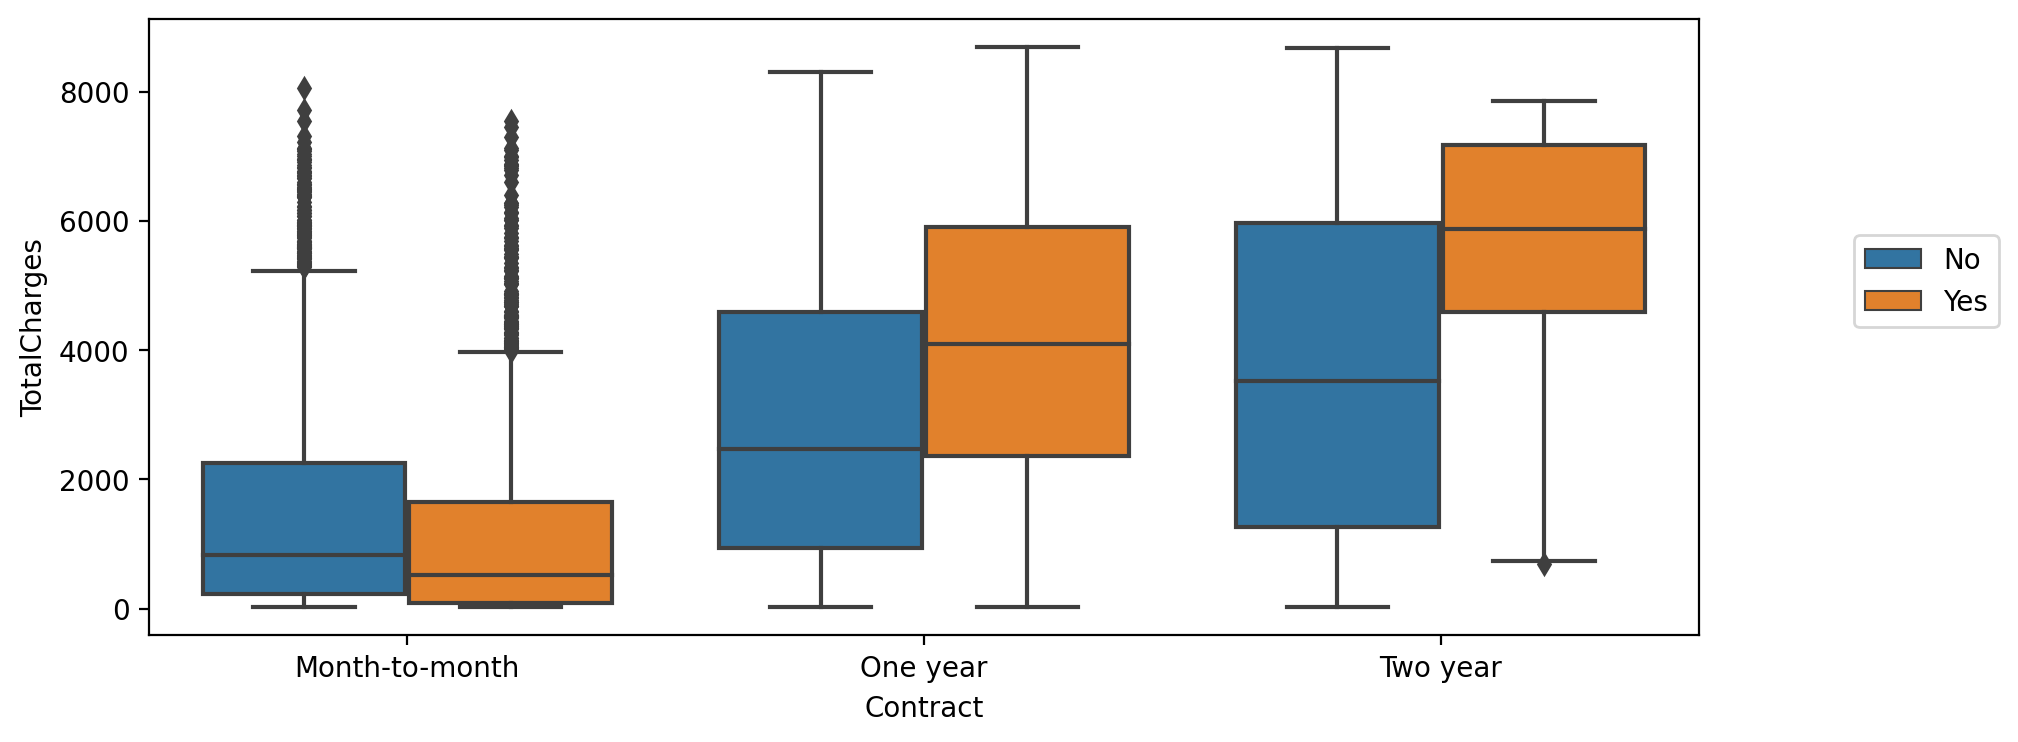

In [9]:
plt.figure(figsize=(10,4),dpi=200)
sns.boxplot(data=df,y='TotalCharges',x='Contract',hue='Churn')
plt.legend(loc=(1.1,0.5))

In [15]:
# Для двухлетних контрактов мы видим меньше людей, уходящих в отток
# Для однолетних и двухлетних контрактов можно заметить, что в отток уходят те клиенты, которые платят больше

**Построим график barplot с корреляции указанных ниже признаков с целевой переменной. Для категориальных признаков сначала сконвертируем их в дамми-переменные, потому что корреляция вычисляется только для числовых колонок.**

    ['gender', 'SeniorCitizen', 'Partner', 'Dependents','PhoneService', 'MultipleLines', 
     'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'InternetService',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

In [12]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [13]:
corr_df  = pd.get_dummies(df[['gender', 'SeniorCitizen', 'Partner', 'Dependents','PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport','StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod','Churn']]).corr()

In [14]:
corr_df['Churn_Yes'].sort_values().iloc[1:-1]

Contract_Two year                         -0.301552
StreamingMovies_No internet service       -0.227578
StreamingTV_No internet service           -0.227578
TechSupport_No internet service           -0.227578
DeviceProtection_No internet service      -0.227578
OnlineBackup_No internet service          -0.227578
OnlineSecurity_No internet service        -0.227578
InternetService_No                        -0.227578
PaperlessBilling_No                       -0.191454
Contract_One year                         -0.178225
OnlineSecurity_Yes                        -0.171270
TechSupport_Yes                           -0.164716
Dependents_Yes                            -0.163128
Partner_Yes                               -0.149982
PaymentMethod_Credit card (automatic)     -0.134687
InternetService_DSL                       -0.124141
PaymentMethod_Bank transfer (automatic)   -0.118136
PaymentMethod_Mailed check                -0.090773
OnlineBackup_Yes                          -0.082307
DeviceProtec

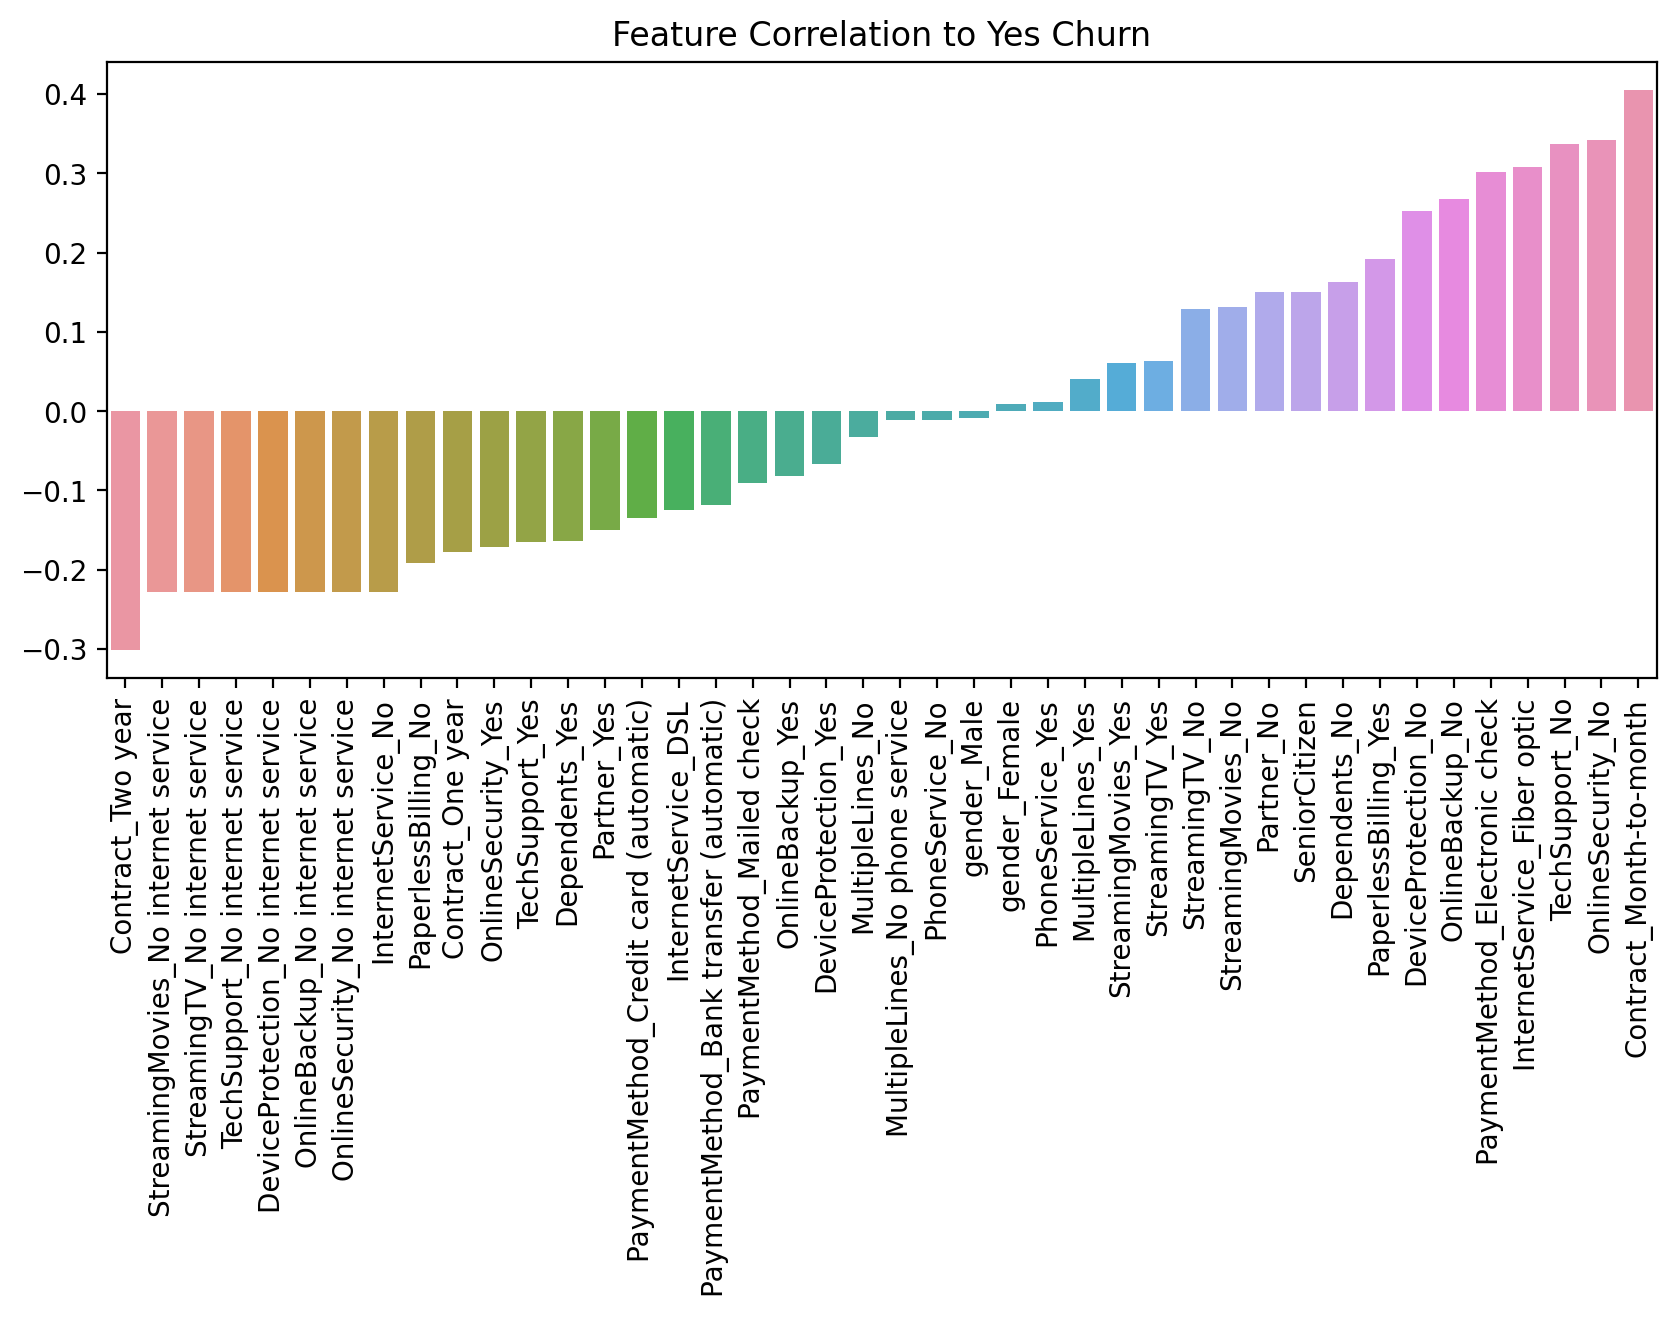

In [16]:
plt.figure(figsize=(10,4),dpi=200)
sns.barplot(x=corr_df['Churn_Yes'].sort_values().iloc[1:-1].index,y=corr_df['Churn_Yes'].sort_values().iloc[1:-1].values)
plt.title("Feature Correlation to Yes Churn")
plt.xticks(rotation=90);

---

# Часть 3: Анализ оттока

**Выполним сегментацию абонентов на основе колонки tenure, создавая "когорты" и выполняя сравнение данных между различными когортами.**

**Перечислим 3 типа контракта (колонка Contract).**

In [17]:
df['Contract'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

**Создадим гистограмму с распределением значений колонки tenure - это количество месяцев, сколько времени человек является (или являлся) абонентом компании.**

<AxesSubplot:xlabel='tenure', ylabel='Count'>

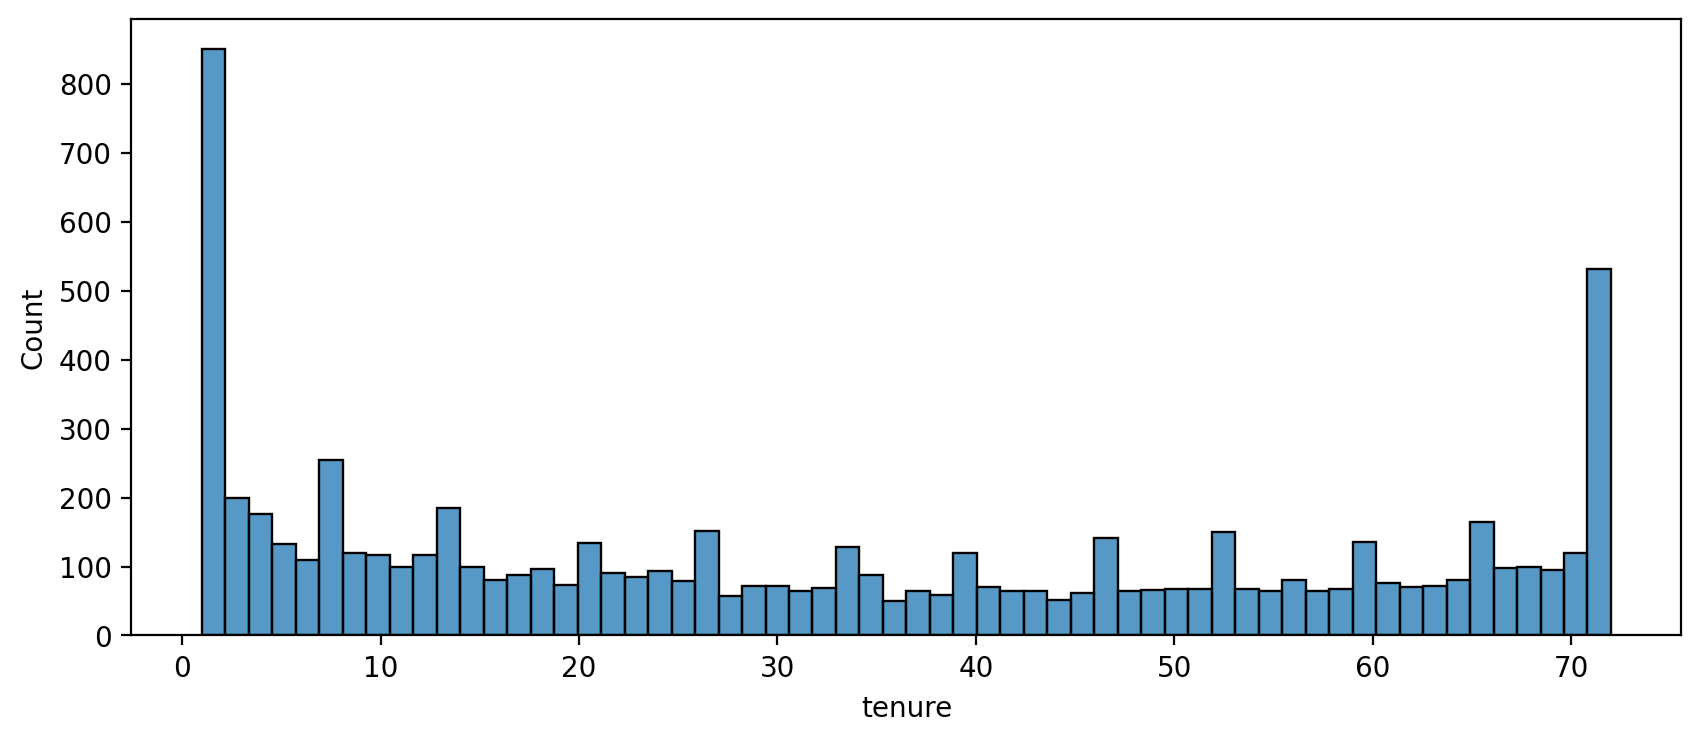

In [18]:
plt.figure(figsize=(10,4),dpi=200)
sns.histplot(data=df,x='tenure',bins=60)

**Построим гистограммы для колонки tenure, разбивая данные по двум колонкам - Churn и Contract.**

<Figure size 2000x600 with 0 Axes>

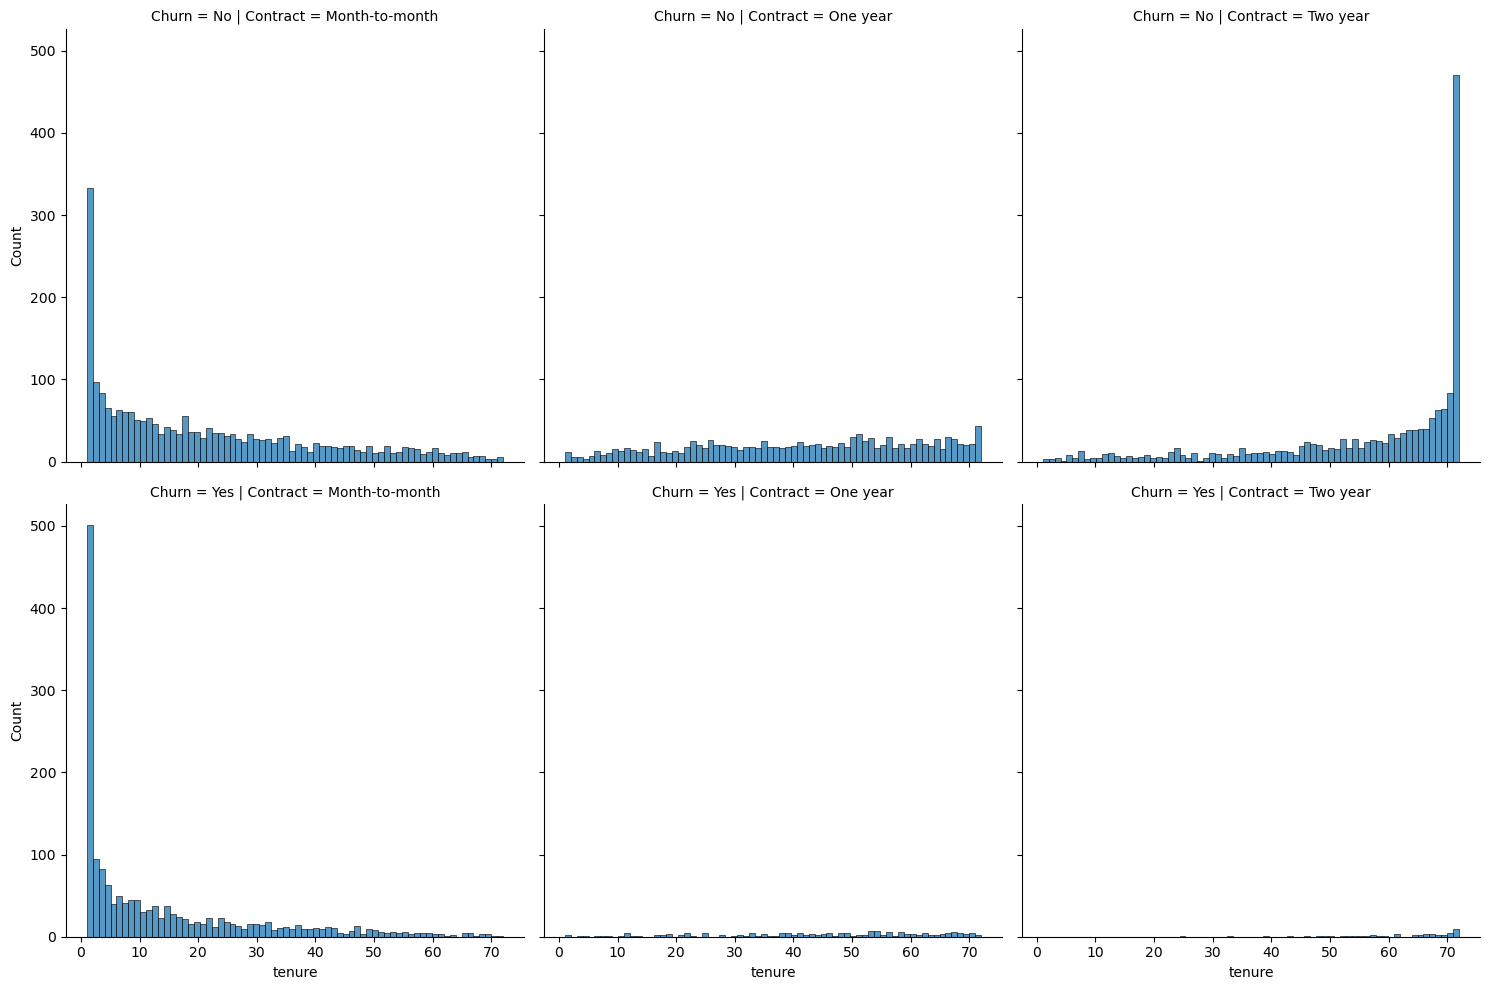

In [19]:
plt.figure(figsize=(10,3),dpi=200)
sns.displot(data=df,x='tenure',bins=70,col='Contract',row='Churn');

In [31]:
# Можно сделать вывод, что основной отток происходит на контрактах Month-to-month, при чем пик оттока приходится на 1-2 месяца

**Построим график scatterplot для колонок Total Charges и Monthly Charges, раскрашивая график цветами по колонке Churn.**

In [20]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

<AxesSubplot:xlabel='MonthlyCharges', ylabel='TotalCharges'>

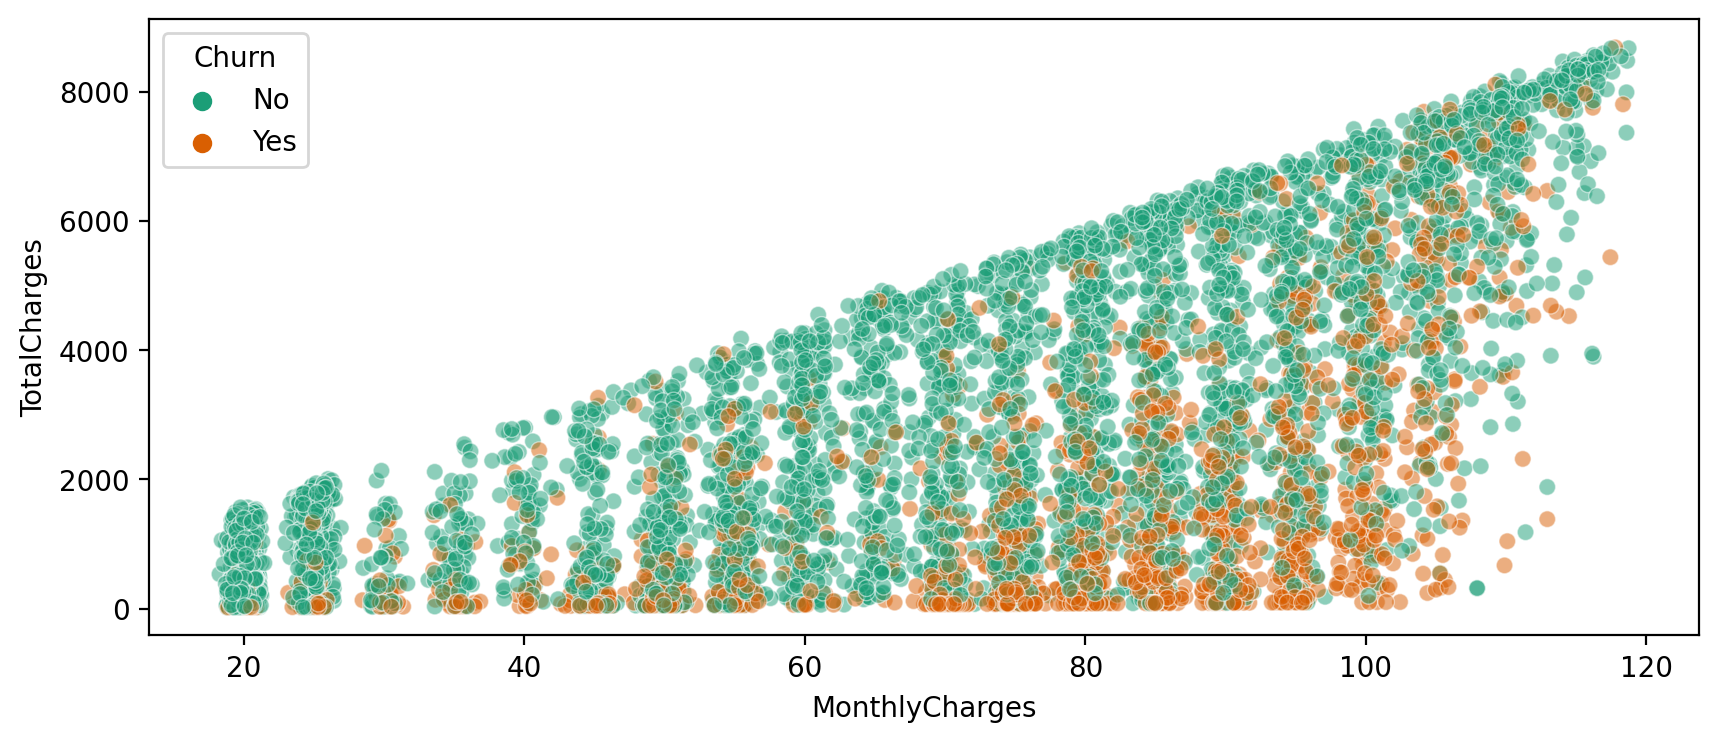

In [21]:
plt.figure(figsize=(10,4),dpi=200)
sns.scatterplot(data=df,x='MonthlyCharges',y='TotalCharges',hue='Churn', linewidth=0.5,alpha=0.5,palette='Dark2')

In [33]:
# На этом графике видно, что в отток уходят те, у кого выше ежемесячные расходы

### Создание когорт (сегментов) по колонке Tenure

**Для начала поместим различные значения tenure (1 месяц, 2 месяца, 3 месяца и так далее) в отдельные когорты (сегменты).**

**Для каждого уникального значения колонки tenure в качестве когорты, вычислим процент оттока (churn rate) - это количество тех людей, кто ушёл в отток в когорте, как процент от общего количества людей в данной когорте. Вычислим такой процент отдельно для каждой когорты. В итоге у нас должны получиться когорты от 1 до 72 месяцев, и с увеличением количества месяцев уровень оттока должен снижаться. Это логично, потому что чем дольше человек пользуется услугами компании, тем вероятнее то, что его всё устраивает, и он продолжит пользоваться этими услугами.**

In [22]:
no_churn = df.groupby(['Churn','tenure']).count().transpose()['No']
yes_churn = df.groupby(['Churn','tenure']).count().transpose()['Yes']

In [23]:
churn_rate = 100 * yes_churn / (no_churn+yes_churn)

In [24]:
churn_rate.transpose()['customerID']

tenure
1     61.990212
2     51.680672
3     47.000000
4     47.159091
5     48.120301
        ...    
68     9.000000
69     8.421053
70     9.243697
71     3.529412
72     1.657459
Name: customerID, Length: 72, dtype: float64

**Построим график процента оттока для различных значений tenure.**

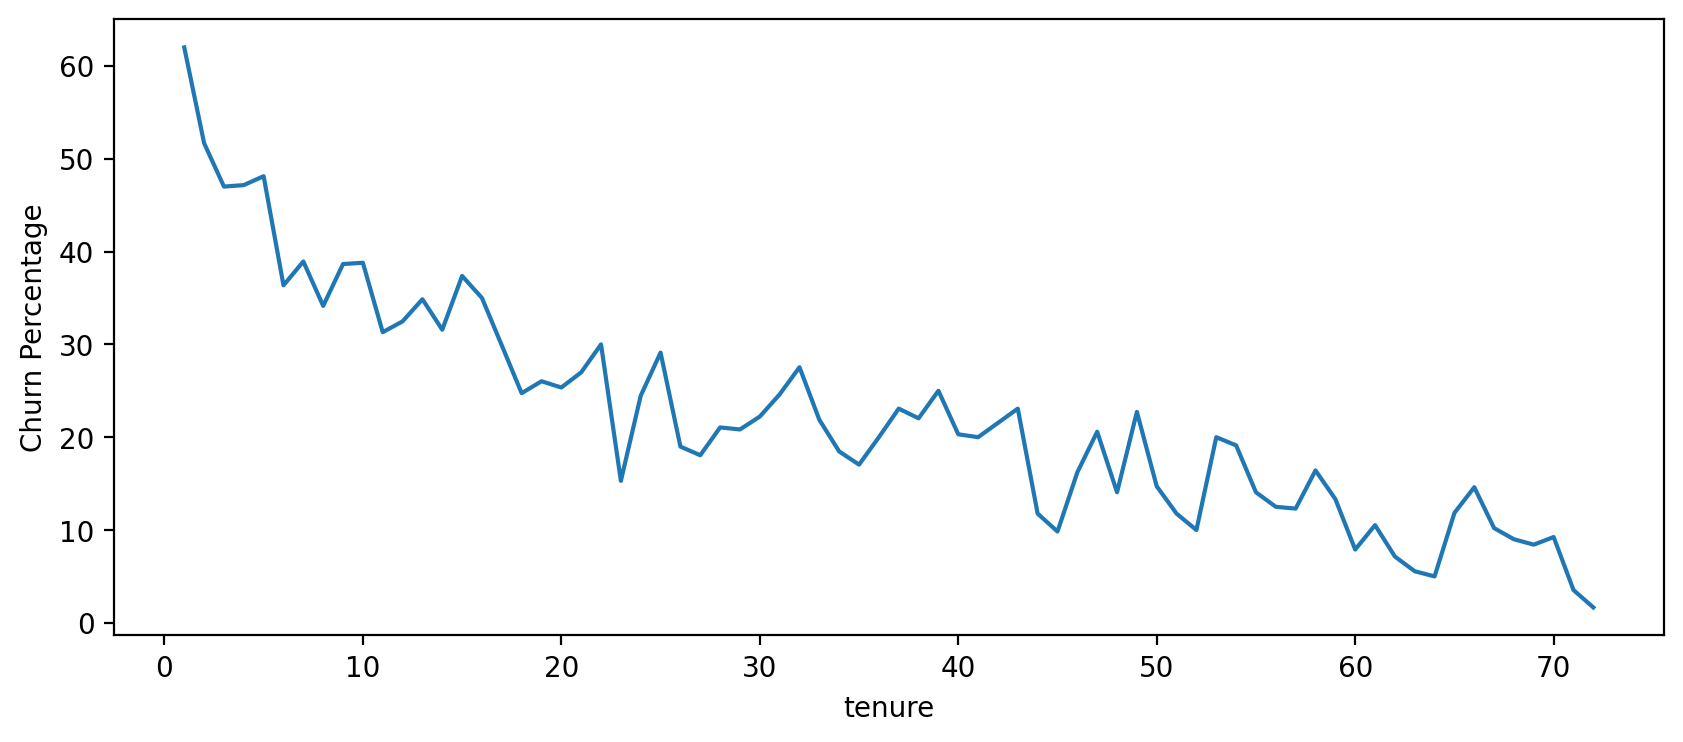

In [25]:
plt.figure(figsize=(10,4),dpi=200)
churn_rate.iloc[0].plot()
plt.ylabel('Churn Percentage');

### Более крупные когорты (сегменты)
**На основе колонки tenure создадим новую колонку с названием "Tenure Cohort", в которой будут следующие 4 категории:**
   * '0-12 месяцев'
   * '12-24 месяцев'
   * '24-48 месяцев'
   * 'Более 48 месяцев'    

In [26]:
def cohort(tenure):
    if tenure < 13:
        return '0-12 Months'
    elif tenure < 25:
        return '12-24 Months'
    elif tenure < 49:
        return '24-48 Months'
    else:
        return "Over 48 Months"

In [27]:
df['Tenure Cohort'] = df['tenure'].apply(cohort)

In [28]:
df.head(10)[['tenure','Tenure Cohort']]

tenure   Tenure Cohort
0       1     0-12 Months
1      34    24-48 Months
2       2     0-12 Months
3      45    24-48 Months
4       2     0-12 Months
5       8     0-12 Months
6      22    12-24 Months
7      10     0-12 Months
8      28    24-48 Months
9      62  Over 48 Months

**Построим график scatterplot для Total Charges и Monthly Charts, раскрашивая график разными цветами по колонке "Tenure Cohort".**

<AxesSubplot:xlabel='MonthlyCharges', ylabel='TotalCharges'>

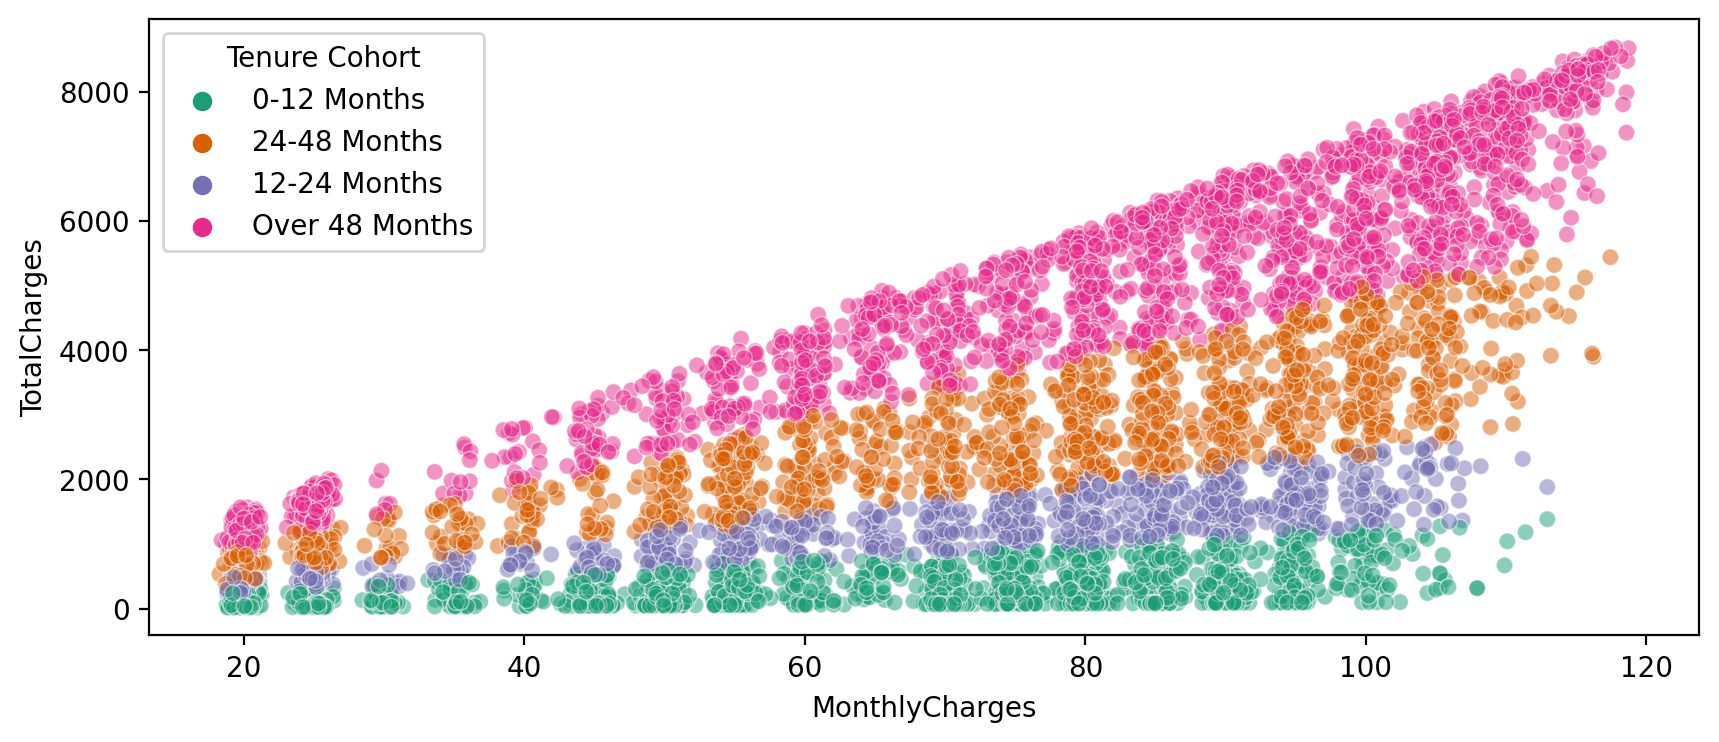

In [29]:
plt.figure(figsize=(10,4),dpi=200)
sns.scatterplot(data=df,x='MonthlyCharges',y='TotalCharges',hue='Tenure Cohort', linewidth=0.5,alpha=0.5,palette='Dark2')

**Построим график countplot с количеством ушедших и не ушедших в отток людей в каждой когорте.**

<AxesSubplot:xlabel='Tenure Cohort', ylabel='count'>

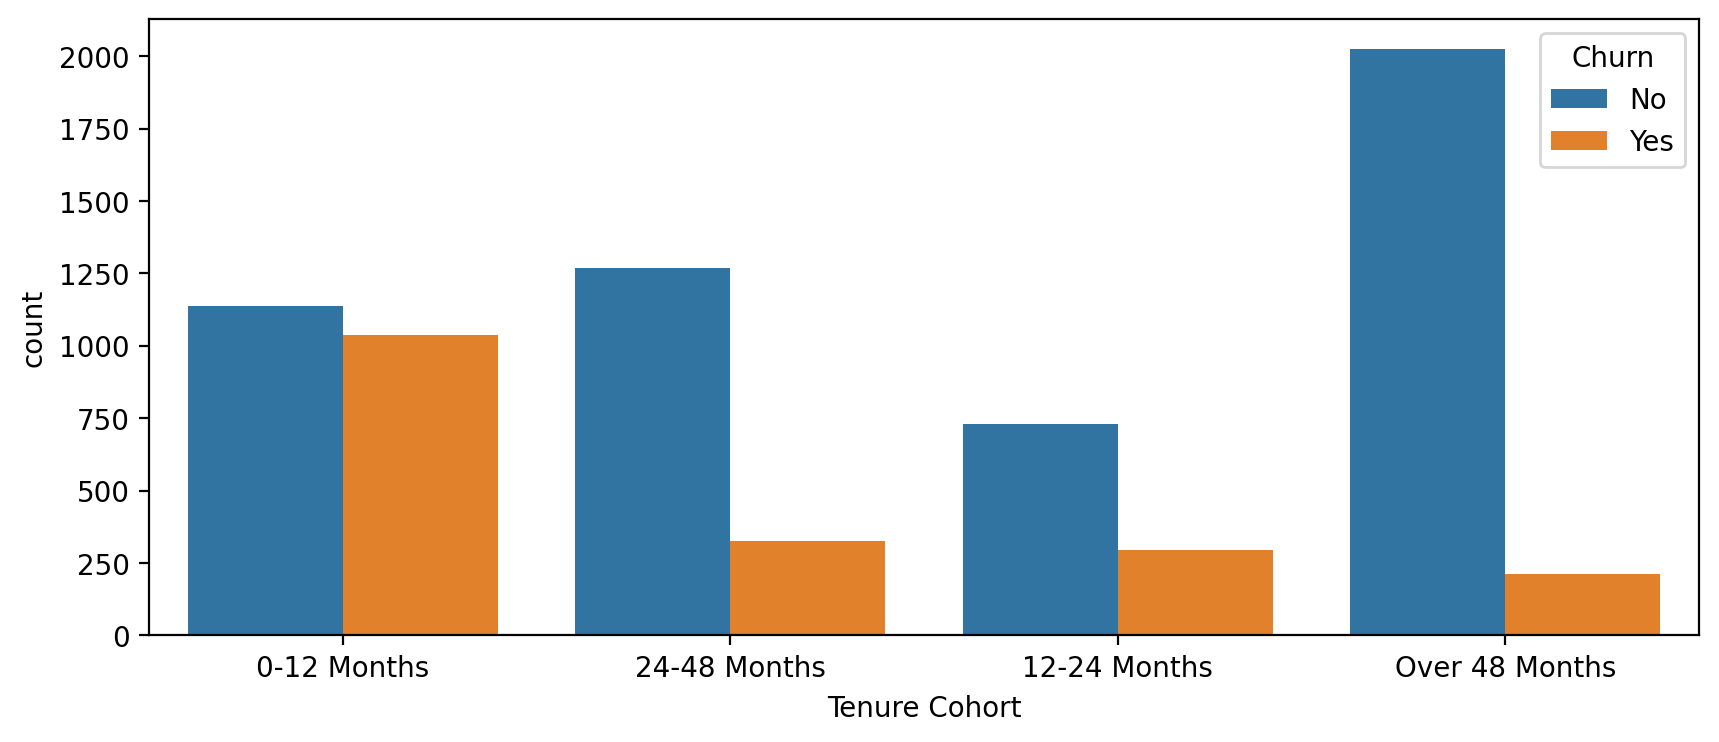

In [30]:
plt.figure(figsize=(10,4),dpi=200)
sns.countplot(data=df,x='Tenure Cohort',hue='Churn')

**Создадим набор графиков CountPlot с количеством людей по различным когортам Tenure Cohort. Для каждого типа контракта создадим отдельный график, и раскрасим эти графики разными цветами по колонке Churn.**

<Figure size 2000x800 with 0 Axes>

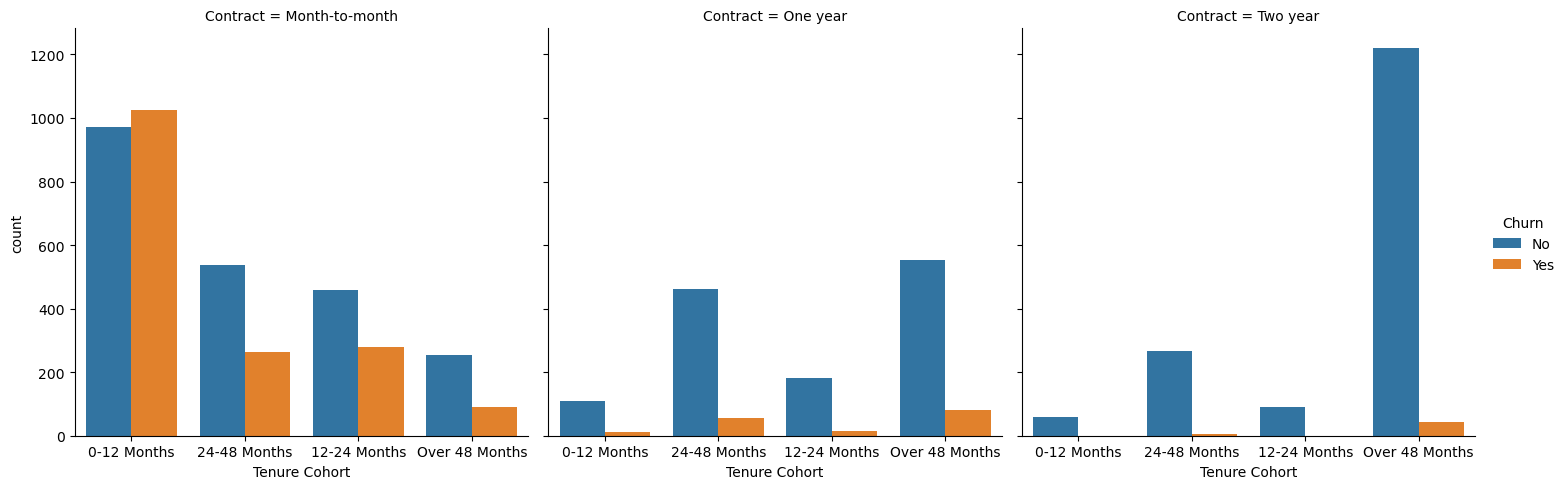

In [32]:
plt.figure(figsize=(10,4),dpi=200)
sns.catplot(data=df,x='Tenure Cohort',hue='Churn',col='Contract',kind='count')

-----

# Часть 4: Предиктивная модель

**Исследуем 4 модели на основе деревьев: одно дерево решений, случайный лес, адаптивный бустинг.**


## Одно дерево решений (Decision Tree)

**Разделим все данные на признаки X и целевую переменную y. Создадим дамми-переменные, где это необходимо, а также посмотрим, есть ли какие-то признаки, которые можно было бы удалить.**

In [34]:
X = df.drop(['Churn','customerID'],axis=1)
X = pd.get_dummies(X,drop_first=True)

In [35]:
y = df['Churn']

**Выполним разбиение данных на обучающий и тестовый наборы (train test split), откладывая в сторону 10% данных для тестирования (random_state=101).**

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

**Построим модель Decision Tree и оценим её работу. Для этого выполним следующие шаги:**
   1. Обучим модель дерева решений.
   2. Оценим метрики работы модели дерева решений.
   2. Посмотрим на важности признаков для получившегося дерева решений.

In [38]:
dt = DecisionTreeClassifier(max_depth=6)

In [39]:
dt.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=6)

In [40]:
preds = dt.predict(X_test)

In [41]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

          No       0.87      0.89      0.88       557
         Yes       0.55      0.49      0.52       147

    accuracy                           0.81       704
   macro avg       0.71      0.69      0.70       704
weighted avg       0.80      0.81      0.80       704



C:\Users\marti\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


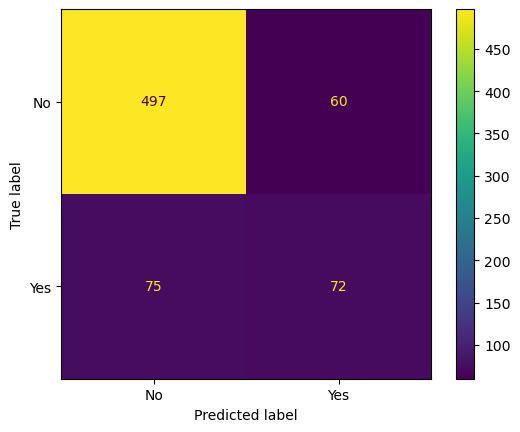

In [42]:
plot_confusion_matrix(dt,X_test,y_test)

In [43]:
imp_feats = pd.DataFrame(data=dt.feature_importances_,index=X.columns,columns=['Feature Importance']).sort_values("Feature Importance")

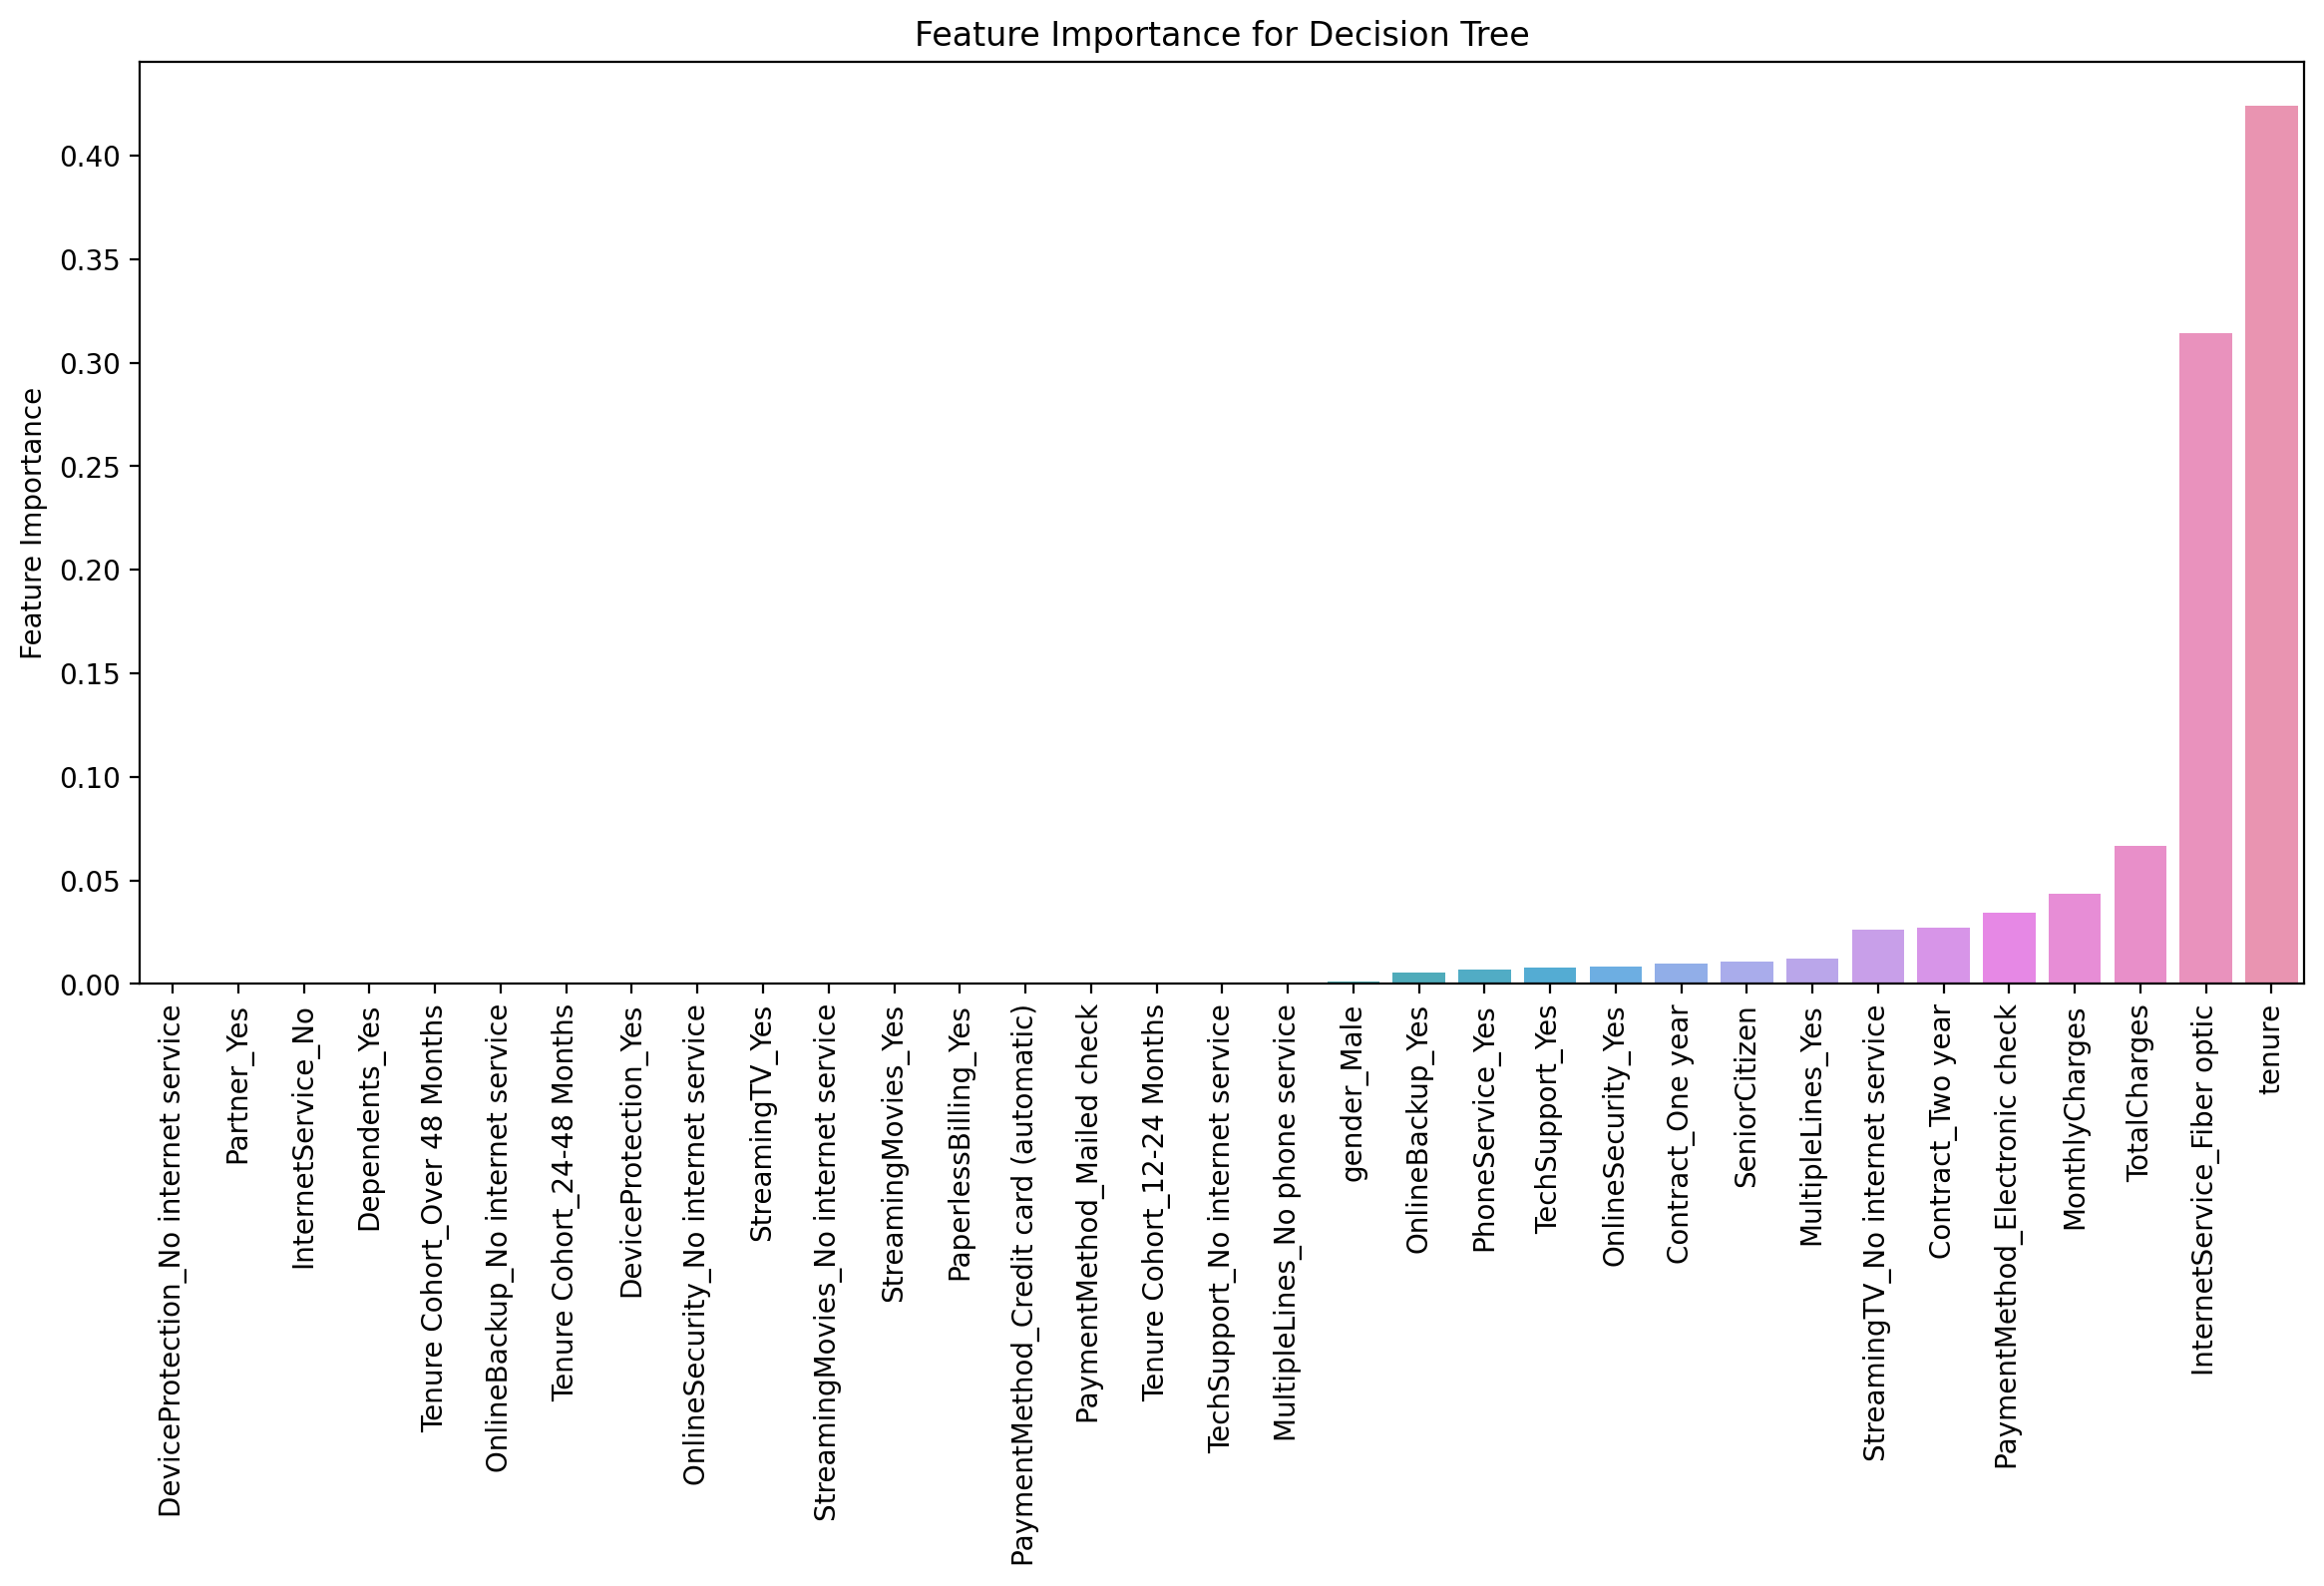

In [44]:
plt.figure(figsize=(14,6),dpi=200)
sns.barplot(data=imp_feats.sort_values('Feature Importance'),x=imp_feats.sort_values('Feature Importance').index,y='Feature Importance')
plt.xticks(rotation=90)
plt.title("Feature Importance for Decision Tree");

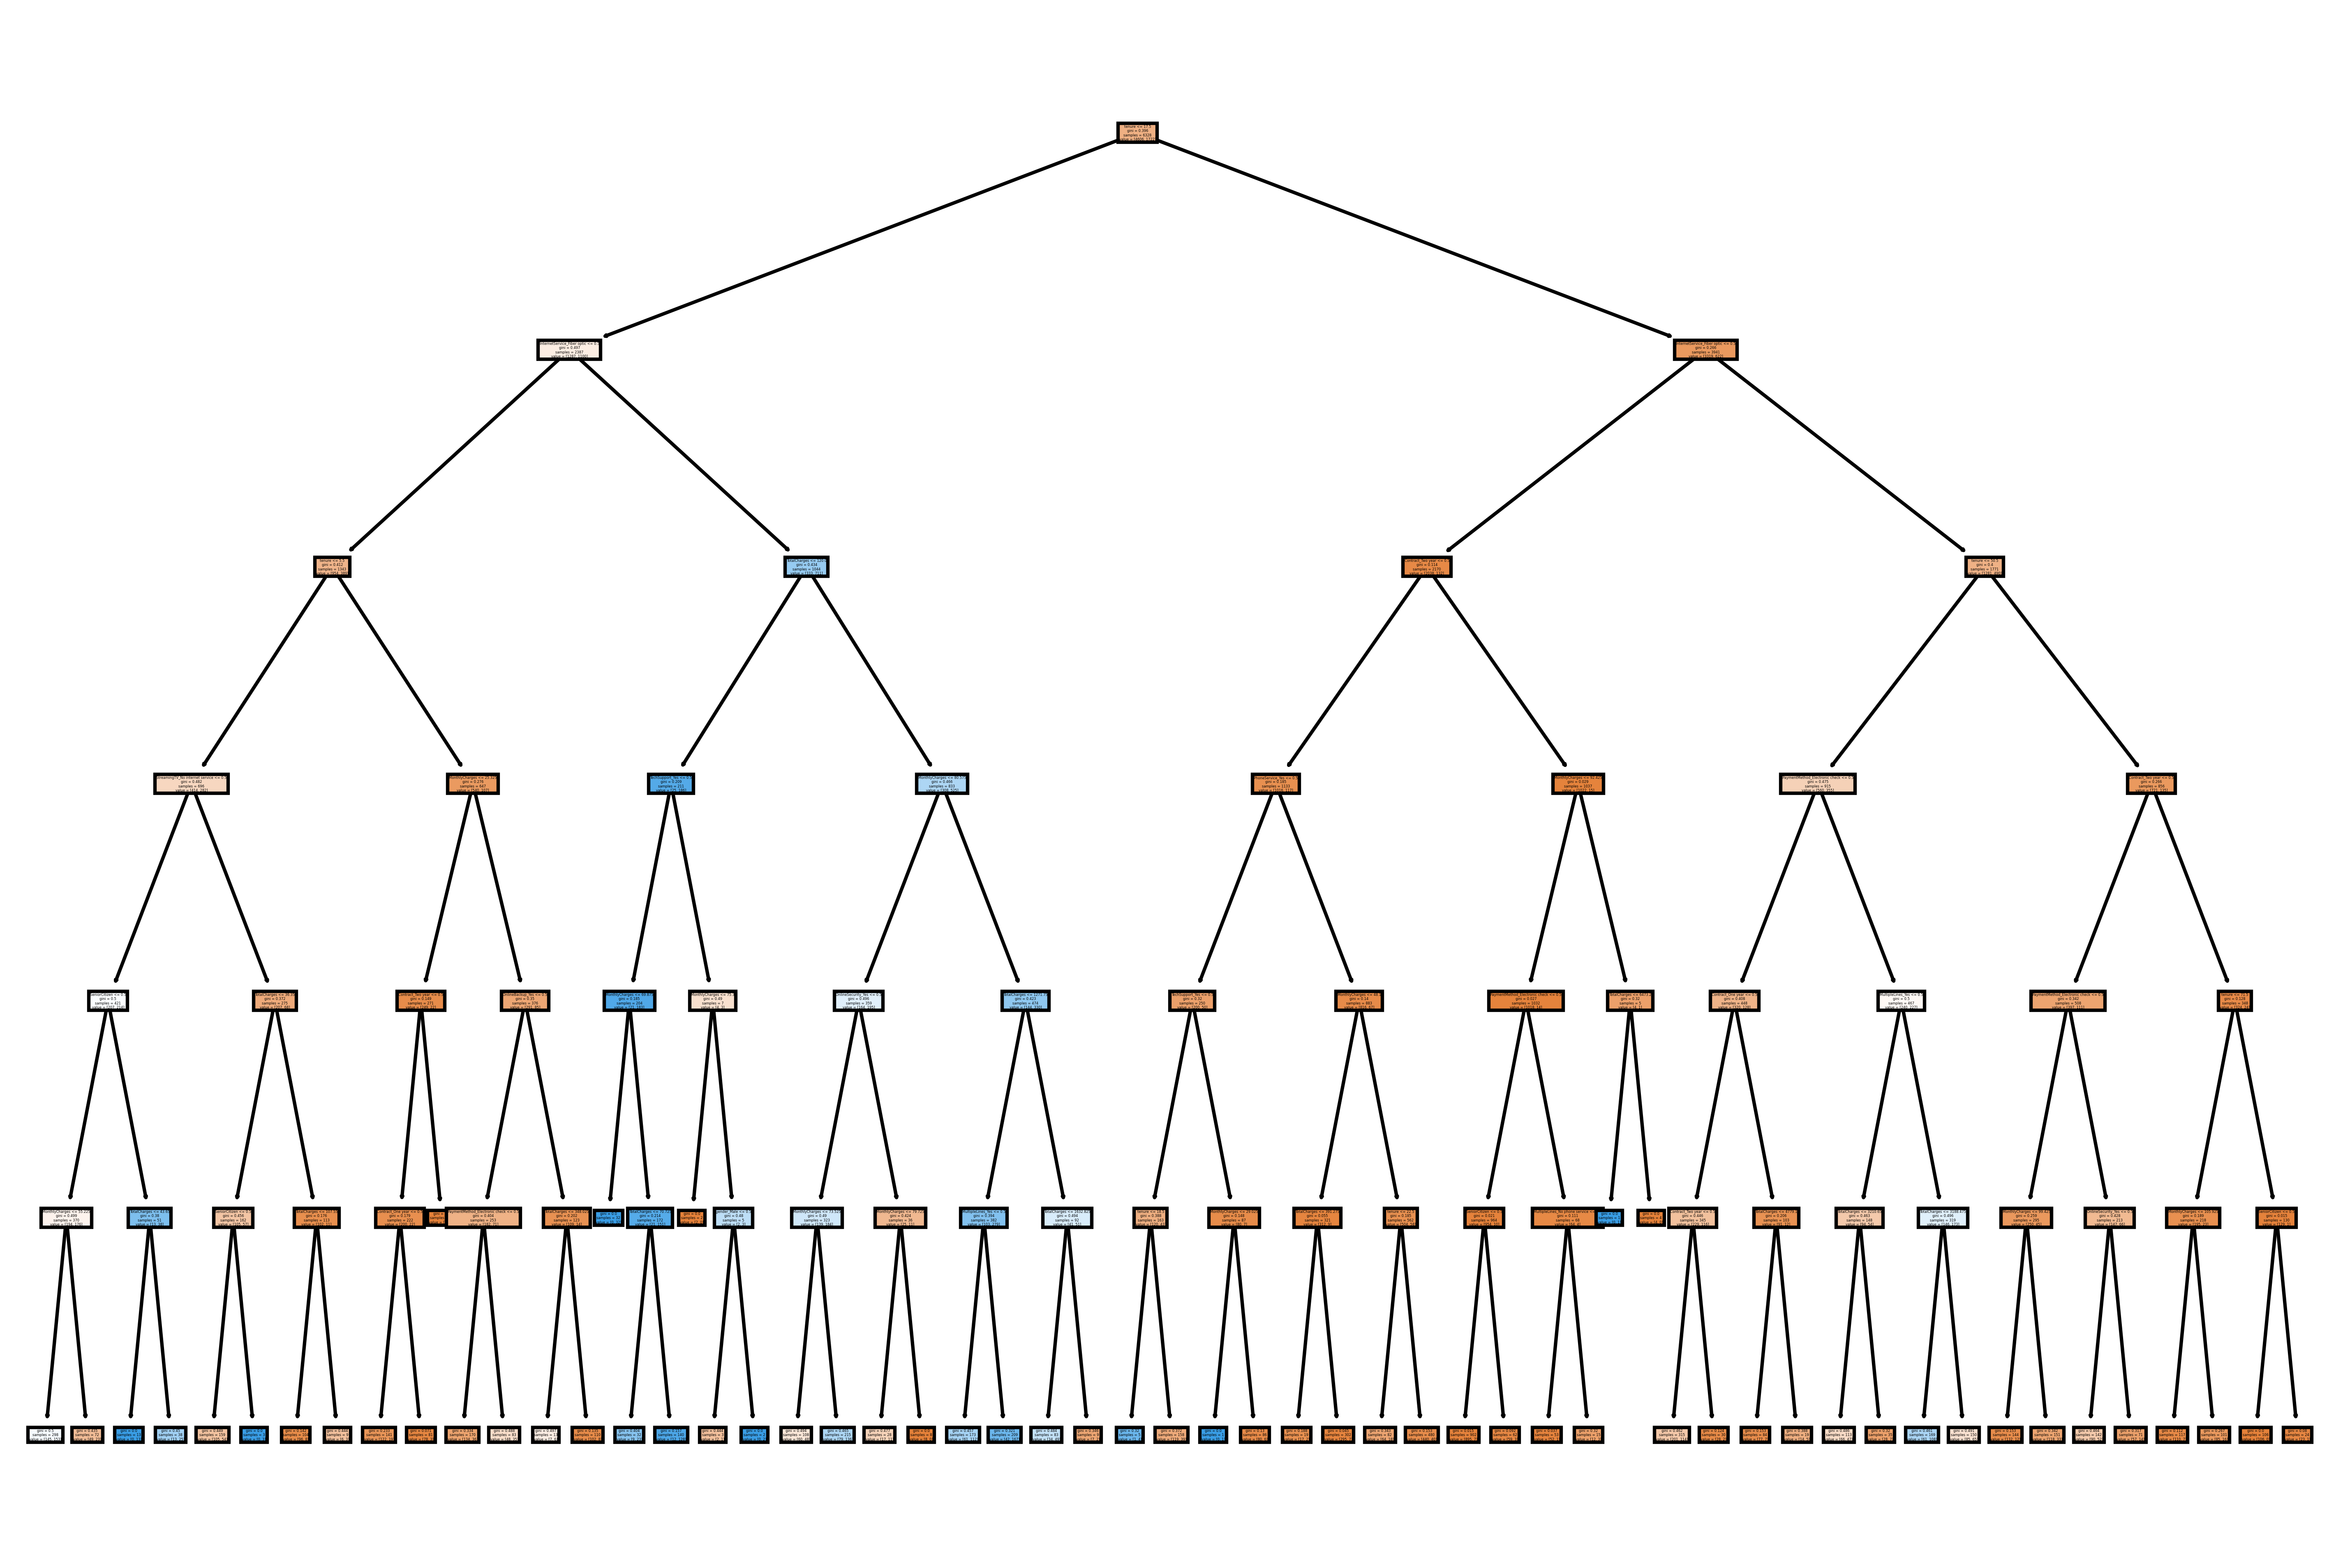

In [47]:
plt.figure(figsize=(12,8),dpi=600)
plot_tree(dt,filled=True,feature_names=X.columns);

## Случайный лес (Random Forest)

**Создадим модель случайного леса, затем выведим отчёт "classification report" и матрицу ошибок для предсказанных результатов на тестовом наборе данных.**

In [48]:
rf = RandomForestClassifier(n_estimators=100)

In [49]:
rf.fit(X_train,y_train)

RandomForestClassifier()

In [50]:
preds = rf.predict(X_test)

In [51]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

          No       0.85      0.88      0.87       557
         Yes       0.49      0.43      0.46       147

    accuracy                           0.79       704
   macro avg       0.67      0.66      0.66       704
weighted avg       0.78      0.79      0.78       704



C:\Users\marti\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


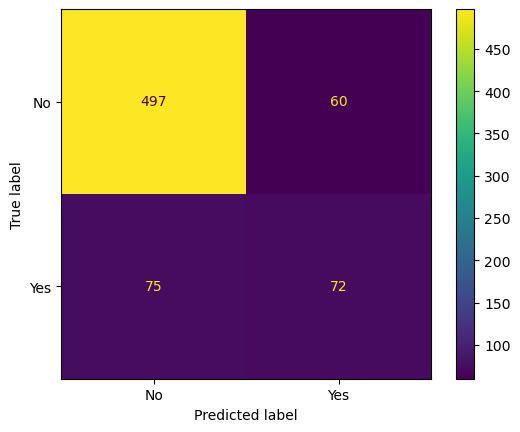

In [52]:
plot_confusion_matrix(dt,X_test,y_test)

## Расширяемые деревья (Boosted Trees)

**Создадим модель AdaBoost, затем выведим отчёт "classification report" и матрицу ошибок для предсказанных результатов на тестовом наборе данных.**

In [53]:
ada_model = AdaBoostClassifier()

In [54]:
ada_model.fit(X_train,y_train)

AdaBoostClassifier()

In [55]:
preds = ada_model.predict(X_test)

In [56]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

          No       0.88      0.90      0.89       557
         Yes       0.60      0.54      0.57       147

    accuracy                           0.83       704
   macro avg       0.74      0.72      0.73       704
weighted avg       0.82      0.83      0.83       704



C:\Users\marti\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


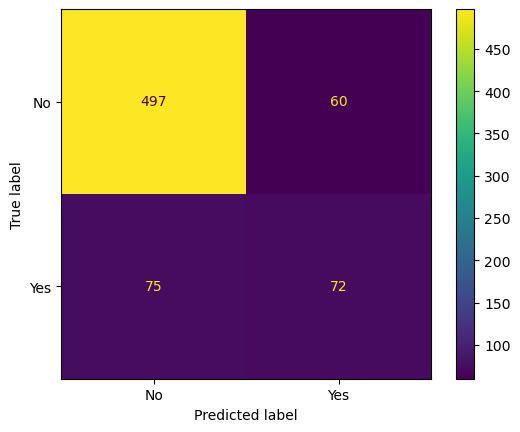

In [57]:
plot_confusion_matrix(dt,X_test,y_test)

In [58]:
# У нас получились наилучшие результаты в модели AdaBoostClassifier, 
# и целом модели показывали очень похожие результаты на этих данных.